In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.lines as mlines

import dgutils
from dgutils import colors as colortools
from numpy import pi as π
from wetting_utils import *
from collections import defaultdict
import matplotlib.transforms as mtransforms
from heprops import helium,potential


%config InlineBackend.figure_format = 'svg'
%matplotlib inline

## Load all the radial density data from disk

In [4]:
L = 25 # Å
r = {}
ϱ = {}
norm = {}

def lab(element,R):
    return f'{element} {R:.1f} Å'

R = np.array([4.0,5.0,6.0,8.0,10.0,12.0])
for el in elements:
    for cR in R:
        with np.load(ψ_filename(cR, el)) as f:
            r[lab(el,cR)] = f['arr_0']
            ϱ[lab(el,cR)] = f['arr_1']
            norm[lab(el,cR)] = normalize_psi_PIMC(ϱ[lab(el,cR)], r[lab(el,cR)])


## First we compute the value of $\langle r/R \rangle$ for each element and R

\begin{equation}
    \left \langle {\frac{r}{R}} \right \rangle = \frac{2\pi L}{N R}\int_0^R r^2 d{r} \varrho(r)
\end{equation}


In [6]:
averoR = defaultdict(list)
for el in elements:
    _averoR = []
    for cR in R:
        _r = r[lab(el,cR)]
        _ϱ = ϱ[lab(el,cR)]
        _averoR.append(2*π*L*intgr.simpson(_r*_r*_ρ, x=_r)/norm[lab(el,cR)]/cR)

    averoR[el] = np.array(_averoR)

## Now we compute the fraction of particles in the well

\begin{equation}
    f_{\text{well}} = \frac{2\pi L}{N} \int_{r_0 - 2r_{\rm He}}^{R} rd{r} \varrho(r)
\end{equation}

In [8]:
rHe = 1.4 # Å

fwell = {}
U_pore_min = {}
for el in elements:
    _fwell = []
    _U_pore_min = []
    for cR in R:

        if el == 'hwall':
            rmin = cR-2*rHe
            _U_pore_min.append(0.0)
        else:
            __r = np.linspace(0,cR-0.1,1000)
            pot = U_pore(__r,cR, ɛ[el], σ[el], n_density[el])
            idx = np.argmin(pot)
            _U_pore_min.append(pot[idx])
            r0 = __r[idx]
            rmin = r0 - 2*rHe
            
        _r = r[lab(el,cR)]
        _ϱ = ϱ[lab(el,cR)]
        min_idx = np.where(_r >= rmin)[0][0]
        
        _fwell.append(2*π*L*intgr.simpson(_r[min_idx:]*_ϱ[min_idx:], x=_r[min_idx:])/norm[lab(el,cR)])
    fwell[el] = np.array(_fwell)
    U_pore_min[el] = np.array(_U_pore_min)


### Get the energy scale corresponding to the minimum of the He-He interaction potential

In [9]:
V = potential.szalewicz_2012
__r = np.linspace(2.5,5,1000)
V_min = np.min(V(__r))

## Create the Combined Plot

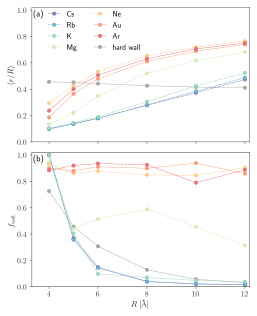

In [10]:
atom_list = ['Cs','Rb','K','Mg','Ne','Au','Ar','hwall']

with plt.style.context('../include/aps.mplstyle'):
    figsize = plt.rcParams['figure.figsize']
    fig,(ax1,ax2) = plt.subplots(2,1,figsize=(figsize[0],2*figsize[1]), sharex=True, sharey=True, constrained_layout=True)
    
    for el in atom_list:
        col = element_colors[el]

        zorder = -1 if el == 'hwall' else 0
        elab = el if el != 'hwall' else 'hard wall'

        ax1.plot(R,averoR[el],'o:', label=elab, color=col,zorder=zorder,
                 mfc=colortools.get_alpha_hex(col,0.7), markersize=3.5, linewidth=0.5, mec=col)
        ax2.plot(R,fwell[el],'o:', label=elab, color=col,zorder=zorder,
                 mfc=colortools.get_alpha_hex(col,0.7), markersize=3.5, linewidth=0.5, mec=col)

    ax1.set_ylabel(r'$\langle r/R\rangle$')
    ax2.set_ylabel(r'$f_{\rm well}$')
    ax2.set_xlabel(r'$R \; [\rm \AA]$')
    ax1.set_xlim(3.3,12.2)
    ax2.set_ylim(0,1.02)
    ax1.legend(handlelength=1.5, ncols=2, loc=(0.06,0.65))

    # Add a possible labels
    trans = mtransforms.ScaledTranslation(1/72, -9/72, fig.dpi_scale_trans)
    ax1.text(0.0, 1.0, '(a)', transform=ax1.transAxes + trans)
    ax2.text(0.0, 1.0, '(b)', transform=ax2.transAxes + trans)
    plt.savefig('../figures/Wetting-parameters_combined_R.pdf')

## Phase Diagram using $f_{\rm well}$

In [11]:
pd_data = []
for el in elements:
    #if el != 'hwall':    
    for i,cR in enumerate(R):
        pd_data.append([cR,U_pore_min[el][i]/V_min,fwell[el][i]])

pd_data = np.array(pd_data)

### Interoplate on a grid to form the decision boundaries

In [12]:
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter

x = pd_data[:,0]
y = pd_data[:,1]
f = pd_data[:,2]

# The phase cutoffs
a, b, c, d = 0, 0.4, 0.6, 1.   # phase1: a<f<b, phase2: b<f<c, phase3: c<f<d

# Interpolate to grid
nx, ny = 100, 100
xi = np.linspace(R.min()-0.5, R.max()+0.5, nx)
yi = np.linspace(pd_data[:,1].min(), pd_data[:,1].max()+1, ny)
Xi, Yi = np.meshgrid(xi, yi)

Fi_lin = griddata(points=(x,y),values=f, xi=(Xi, Yi),method='linear')

# nearest-neighbor for extrapolation 
Fi_nn  = griddata((x, y), f, (Xi, Yi), method='nearest')

# fill NaNs from linear with nearest (keeps phases unchanged outside)
Fi = np.where(np.isnan(Fi_lin), Fi_nn, Fi_lin)

# Gentle smoothing (comment out if you want raw interpolation)
Fi = gaussian_filter(Fi, sigma=2.5)

# Mask out areas outside convex hull (griddata returns NaN there)
Fi_masked = np.ma.masked_invalid(Fi)

# Discrete phase coloring
cmap = ListedColormap([colortools.get_alpha_hex(element_colors['Cs'],0.35), 
                       colortools.get_alpha_hex(element_colors['Mg'],0.35), 
                       colortools.get_alpha_hex(element_colors['Ar'],0.35)])
bounds = [a, b, c, d]
_norm = BoundaryNorm(bounds, cmap.N)

## The wetting phase diagram

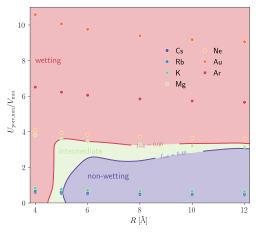

In [13]:
with plt.style.context('../include/aps.mplstyle'):
    figsize = plt.rcParams['figure.figsize']
    fig, ax = plt.subplots(constrained_layout=True, figsize=(figsize[0],0.9*figsize[0]))

    # Use contourf for crisp discrete regions
    cf = ax.contourf(Xi, Yi, Fi_masked, levels=bounds, cmap=cmap, norm=_norm)

    # Phase boundary lines (f=b and f=c)
    cs = ax.contour(Xi, Yi, Fi_masked, levels=[b], colors=element_colors['Cs'], linewidths=1)
    ax.clabel(cs, inline=True, fmt={b: rf"$f_{{\rm well}}={b:.2f}$"}, fontsize=6)

    cs = ax.contour(Xi, Yi, Fi_masked, levels=[c], colors=element_colors['Ar'], linewidths=1)
    ax.clabel(cs, inline=True, fmt={c: rf"$f_{{\rm well}}={c:.2f}$"}, fontsize=6)

    # The raw fwell data points
    for el in atom_list:
        col = element_colors[el]
        elab = el if el != 'hwall' else '__nolabel__'
        if el != 'hwall':
            #ax.plot(R,U_pore_min[el]/V_min,'o', label=elab, color=col,zorder=1000,
            #        mfc=colortools.get_alpha_hex(col,0.7), markersize=2.5, mec=col)
            ax.plot(R,U_pore_min[el]/V_min,'o', label=elab,zorder=1000,
                    mfc=col, markersize=3.5, mec='w', mew=0.3)


    # set cbar_on = True to show colorbar
    cbar_on = False
    if cbar_on:
        # Colorbar with phase labels
        # Put ticks in the middle of each phase interval
        ticks = [(a+b)/2, (b+c)/2, (c+d)/2]
        labels = ["non-wetting", "intermediate", "wetting"]

        mappable = plt.cm.ScalarMappable(norm=_norm, cmap=cmap)
        mappable.set_array([])  # needed for older Matplotlib
        cbar = fig.colorbar(mappable, ax=ax, ticks=ticks, boundaries=bounds, spacing='proportional', 
                            pad=0.01)
        plt.setp(cbar.ax.get_yticklabels(), rotation=90, va='center', ha='center')
        cbar.ax.set_yticklabels(labels)
    else:
        ax.text(4,8,'wetting',ha='left',va='center', color=element_colors['Ar'])
        ax.text(4.9,2.9,'intermediate',ha='left',va='center', color=element_colors['Mg'])
        ax.text(6,1.5,'non-wetting',ha='left',va='center', color=element_colors['Cs'])


    ax.set_xlabel(r"$R\; [{\rm \AA}]$")
    ax.set_ylabel(r"$U_{\rm pore, min}/V_{\rm min}$")
    ax.legend(ncol=2, loc=(0.6,0.57),frameon=False, handlelength=0.5)

    ax.set_xlim(3.8,12.2)
    ax.set_ylim(0,11)

    plt.savefig('../figures/wetting_phase_diagram.pdf')
